In [6]:
import numpy as np
#import pandas as pd
import polars as pl
import pymc as pm
import pytensor.tensor as pt
import arviz as az

In [11]:
lf = pl.scan_csv("..\\results\\placefields.csv")

# Map recording_id -> 0..R-1
rec_map = (
    lf.select("recording_id")
      .unique()
      .sort("recording_id")
      .with_row_index("rec_idx")  # 0-based codes
)

# Join lazily, only collect at the end
df = (
    lf.join(rec_map, on="recording_id")
      .with_columns(
          pl.col("putative_contextual").cast(pl.Int8).alias("contextual"),
          pl.col("fwhm").cast(pl.Float64).alias("size"),    
      )
      .select("rec_idx", "neuron_id", "size", "contextual")
      .collect()
      
)

# to NumPy for PyMC
y          = df["size"].to_numpy()
rec_idx    = df["rec_idx"].to_numpy().astype(np.int64)
contextual = df["contextual"].to_numpy().astype(np.int8)
R = int(df["rec_idx"].max()) + 1
N = y.shape[0]

In [3]:
# ---------- config ----------
PATH = r"..\results\placefields.csv"   # <-- adjust to your file
SEPARATOR = ","                        # for csv file
SIZE_COL = "fwhm"                      # your size column
# ----------------------------

import polars as pl
import numpy as np
import pymc as pm
import pytensor.tensor as pt
import arviz as az

# ----------------------------
# 1) Load with Polars (eager)
# ----------------------------
df_main = pl.read_csv(PATH, separator=SEPARATOR)

# sanity: make sure expected columns exist (rename here if yours differ)
needed = {"recording_id", "neuron_id", SIZE_COL, "putative_contextual"}
missing = needed - set(df_main.columns)
if missing:
    raise ValueError(f"Missing columns: {missing}. Have: {df_main.columns}")

# map recording_id -> 0..R-1 (stable)
rec_map = (
    df_main.select("recording_id")
           .unique()
           .sort("recording_id")
           .with_row_index(name="rec_idx")
)

df = (
    df_main.join(rec_map, on="recording_id")
           .with_columns(
               pl.col("putative_contextual").cast(pl.Int8).alias("contextual"),
               pl.col(SIZE_COL).cast(pl.Float64).alias("size"),
           )
           .select("rec_idx", "neuron_id", "size", "contextual")
)

# to NumPy for PyMC
y          = df["size"].to_numpy()
rec_idx    = df["rec_idx"].to_numpy().astype(np.int64)
contextual = df["contextual"].to_numpy().astype(np.int8)
R = int(df["rec_idx"].max()) + 1
N = y.shape[0]

# y, rec_idx, R already defined; y must be strictly > 0
y_pos = np.clip(y, 1e-6, None)        # enforce positivity
y_log = np.log(y_pos)


ybar   = float(y_log.mean())
ysd    = float(y_log.std(ddof=0))
y_std  = (y_log - ybar) / ysd

# ----------------------------
# 2) Model A: single component
#     (hierarchical LogNormal via Normal on log-scale)
#     non-centered, standardized
# ----------------------------
with pm.Model() as model_single:
    mu0_std   = pm.Normal("mu0_std", 0.0, 1.5)
    tau_std   = pm.HalfNormal("tau_std", 0.5)
    sigma_std = pm.HalfNormal("sigma_std", 0.5)

    z_r = pm.Normal("z_r", 0.0, 1.0, shape=R)
    mu_r_std = pm.Deterministic("mu_r_std", mu0_std + tau_std * z_r[rec_idx])

    y_std_obs = pm.Normal("y_std_obs", mu=mu_r_std, sigma=sigma_std, observed=y_std)

    # back-transform to log-scale parameters for interpretability
    mu0   = pm.Deterministic("mu0",   mu0_std * ysd + ybar)
    tau   = pm.Deterministic("tau",   tau_std * ysd)
    sigma = pm.Deterministic("sigma", sigma_std * ysd)

    idata_single = pm.sample(
        draws=2000, tune=2000, chains=4, random_seed=42,
        init="jitter+adapt_diag", target_accept=0.97,
        idata_kwargs={"log_likelihood": True}
    )
    ppc_single = pm.sample_posterior_predictive(idata_single)

loo_single = az.loo(idata_single, var_name="y_std_obs", pointwise=True)

print("\n=== Model A (single) key params ===")
print(az.summary(idata_single, var_names=["mu0","tau","sigma"]))

# ----------------------------
# 3) Model B: two-component mixture
#     (mixture of Normals on standardized log-scale)
#     contextual tilt + recording random intercept on logit(pi2)
#     non-centered per-component location
# ----------------------------
with pm.Model() as model_mix:
    # component locations: non-centered hierarchies on standardized scale
    mu_center_std = pm.Normal("mu_center_std", 0.0, 1.5)
    delta_std = pm.HalfNormal("delta_std", 0.7) # > 0 separation
    mu01_std = pm.Deterministic("mu01_std", mu_center_std - 0.5 * delta_std)
    mu02_std = pm.Deterministic("mu02_std", mu_center_std + 0.5 * delta_std)
    #mu01_std = pm.Normal("mu01_std", 0.0, 1.5)
    #mu02_std = pm.Normal("mu02_std", 0.0, 1.5)

    tau1_std = pm.HalfNormal("tau1_std", 0.5)
    tau2_std = pm.HalfNormal("tau2_std", 0.5)

    sigma1_std = pm.HalfNormal("sigma1_std", 0.4)
    sigma2_std = pm.HalfNormal("sigma2_std", 0.4)

    z_r1 = pm.Normal("z_r1", 0.0, 1.0, shape=R)
    z_r2 = pm.Normal("z_r2", 0.0, 1.0, shape=R)

    mu_r1_std = pm.Deterministic("mu_r1_std", mu01_std + tau1_std * z_r1[rec_idx])
    mu_r2_std = pm.Deterministic("mu_r2_std", mu02_std + tau2_std * z_r2[rec_idx])

    # mixture gate: logistic regression with recording random intercept
    alpha0 = pm.Normal("alpha0", 0.0, 2.0)
    sigma_alpha = pm.HalfNormal("sigma_alpha", 0.3)
    a_r = pm.Normal("a_r", 0.0, sigma_alpha, shape=R)
    beta = pm.Normal("beta", 0.0, 1.0)

    logit_pi2 = alpha0 + a_r[rec_idx] + beta * contextual
    pi2 = pm.Deterministic("pi2", pm.math.sigmoid(logit_pi2))
    w = pt.stack([1.0 - pi2, pi2], axis=1)  # (N,2)

    # two Normal components on standardized log-scale
    comp1 = pm.Normal.dist(mu=mu_r1_std, sigma=sigma1_std)
    comp2 = pm.Normal.dist(mu=mu_r2_std, sigma=sigma2_std)

    y_std_mix = pm.Mixture("y_std_mix", w=w, comp_dists=[comp1, comp2], observed=y_std)

    # back-transform component params to log scale
    mu01   = pm.Deterministic("mu01",   mu01_std * ysd + ybar)
    mu02   = pm.Deterministic("mu02",   mu02_std * ysd + ybar)
    tau1   = pm.Deterministic("tau1",   tau1_std * ysd)
    tau2   = pm.Deterministic("tau2",   tau2_std * ysd)
    sigma1 = pm.Deterministic("sigma1", sigma1_std * ysd)
    sigma2 = pm.Deterministic("sigma2", sigma2_std * ysd)

    idata_mix = pm.sample(
        draws=4000, tune=4000, chains=4, random_seed=43,
        init="jitter+adapt_diag", target_accept=0.99,
        nuts_kwargs=dict(max_treedepth=15),
        idata_kwargs={"log_likelihood": True}
    )
    ppc_mix = pm.sample_posterior_predictive(idata_mix)

loo_mix = az.loo(idata_mix, var_name="y_std_mix", pointwise=True)

print("\n=== Model B (mixture) key params ===")
print(az.summary(idata_mix, var_names=["mu01","mu02","sigma1","sigma2","beta","alpha0","sigma_alpha"]))

# ----------------------------
# 4) Model comparison (LOO)
# ----------------------------
cmp = az.compare({"single": idata_single, "mixture": idata_mix}, method="BB-pseudo-BMA", ic="loo")
print("\n=== Model comparison (lower LOO is better) ===")
print(cmp)

# ----------------------------
# 5) Posterior P(component=2) per neuron
# ----------------------------
# We compute responsibilities r2 = pi2 * N(y|mu2,s2) / [ (1-pi2)*N(y|mu1,s1) + pi2*N(y|mu2,s2) ]
import xarray as xr

post = idata_mix.posterior  # dims: chain, draw, ...
# grab draws for each term; ensure shapes broadcast to (chain, draw, N)
pi2_draws    = post["pi2"].values                    # (chain, draw, N)
mu1_draws    = post["mu_r1_std"].values              # (chain, draw, N)
mu2_draws    = post["mu_r2_std"].values              # (chain, draw, N)
sigma1_draws = post["sigma1_std"].values[..., None]  # (chain, draw, 1)
sigma2_draws = post["sigma2_std"].values[..., None]  # (chain, draw, 1)

y_std_broadcast = y_std[None, None, :]               # (1,1,N)

def normal_logpdf(x, mu, sd):
    return -0.5*np.log(2*np.pi) - np.log(sd) - 0.5*((x - mu)/sd)**2

lp1 = normal_logpdf(y_std_broadcast, mu1_draws, sigma1_draws)
lp2 = normal_logpdf(y_std_broadcast, mu2_draws, sigma2_draws)

# responsibilities with log-sum-exp for stability
num = np.exp(np.log(pi2_draws) + lp2)
den = num + np.exp(np.log(1.0 - pi2_draws) + lp1)
r2  = num / den  # (chain, draw, N)

p_component2 = r2.mean(axis=(0,1))   # average over chains & draws -> (N,)
# attach to Polars frame (optional)
df = df.with_columns(pl.Series("p_component2", p_component2))

# quick text summaries
print("\n=== Contextual effect (beta) ===")
print(az.summary(idata_mix, var_names=["beta"]))

print("\nTop 10 neurons most likely in component 2:")
print(df.select(["neuron_id","rec_idx","size","contextual"])   # join back rec_id for readability
        .with_columns(pl.Series("p_component2", p_component2))
        .sort("p_component2", descending=True)
        .head(10))


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu0_std, tau_std, sigma_std, z_r]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 40 seconds.
Sampling: [y_std_obs]


Output()

c:\Users\anneluka\.conda\envs\bayes-pymc\Lib\site-packages\arviz\stats\stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(



=== Model A (single) key params ===
        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
mu0    2.898  0.260   2.429    3.417      0.007    0.004    1528.0    2160.0   
tau    0.696  0.197   0.334    1.059      0.005    0.002    1871.0    2606.0   
sigma  0.585  0.065   0.465    0.706      0.001    0.001    3176.0    4430.0   

       r_hat  
mu0      1.0  
tau      1.0  
sigma    1.0  


c:\Users\anneluka\.conda\envs\bayes-pymc\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
Initializing NUTS using jitter+adapt_diag...
c:\Users\anneluka\.conda\envs\bayes-pymc\Lib\site-packages\pytensor\link\c\cmodule.py:2968: UserWarning: PyTensor could not link to a BLAS installation. Operations that might benefit from BLAS will be severely degraded.
This usually happens when PyTensor is installed via pip. We recommend it be installed via conda/mamba/pixi instead.
Alternatively, you can use an experimental backend such as Numba or JAX th

Output()

Sampling 4 chains for 4_000 tune and 4_000 draw iterations (16_000 + 16_000 draws total) took 433 seconds.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [y_std_mix]


Output()

c:\Users\anneluka\.conda\envs\bayes-pymc\Lib\site-packages\arviz\stats\stats.py:1057: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
c:\Users\anneluka\.conda\envs\bayes-pymc\Lib\site-packages\arviz\stats\stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(



=== Model B (mixture) key params ===
              mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu01         2.719  0.139   2.447    2.977      0.024    0.019      41.0   
mu02         3.088  0.282   2.642    3.603      0.083    0.002      11.0   
sigma1       0.284  0.167   0.123    0.635      0.074    0.049       7.0   
sigma2       0.474  0.213   0.126    0.816      0.081    0.021       8.0   
beta         1.164  2.093  -2.961    3.644      0.992    0.548       7.0   
alpha0      -0.603  1.129  -2.116    1.750      0.507    0.263       7.0   
sigma_alpha  0.255  0.186   0.004    0.587      0.007    0.003     528.0   

             ess_tail  r_hat  
mu01             46.0   1.06  
mu02             51.0   1.28  
sigma1           29.0   1.51  
sigma2           33.0   1.47  
beta             27.0   1.53  
alpha0           26.0   1.53  
sigma_alpha     422.0   1.01  


c:\Users\anneluka\.conda\envs\bayes-pymc\Lib\site-packages\arviz\stats\stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
c:\Users\anneluka\.conda\envs\bayes-pymc\Lib\site-packages\arviz\stats\stats.py:1057: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
c:\Users\anneluka\.conda\envs\bayes-pymc\Lib\site-packages\arviz\stats\stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posteri


=== Model comparison (lower LOO is better) ===
         rank   elpd_loo      p_loo  elpd_diff    weight         se       dse  \
mixture     0 -53.837104  23.529920   0.000000  0.999772  10.129904  0.000000   
single      1 -76.792270  14.903648  22.955166  0.000228   8.181090  5.599273   

         warning scale  
mixture     True   log  
single      True   log  

=== Contextual effect (beta) ===
       mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
beta  1.164  2.093  -2.961    3.644      0.992    0.548       7.0      27.0   

      r_hat  
beta   1.53  

Top 10 neurons most likely in component 2:
shape: (10, 5)
┌───────────┬─────────┬────────┬────────────┬──────────────┐
│ neuron_id ┆ rec_idx ┆ size   ┆ contextual ┆ p_component2 │
│ ---       ┆ ---     ┆ ---    ┆ ---        ┆ ---          │
│ str       ┆ u32     ┆ f64    ┆ i8         ┆ f64          │
╞═══════════╪═════════╪════════╪════════════╪══════════════╡
│ 24        ┆ 8       ┆ 87.52  ┆ 1          ┆ 0.

c:\Users\anneluka\.conda\envs\bayes-pymc\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu0_std, tau_std, sigma_std, z_r, nu_minus2]


Output()

Sampling 4 chains for 3_000 tune and 3_000 draw iterations (12_000 + 12_000 draws total) took 57 seconds.
Sampling: [y_std_obs]


Output()

            mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu0        2.988  0.177   2.702    3.344      0.004    0.003    2589.0   
tau        0.323  0.161   0.048    0.625      0.003    0.002    2070.0   
sigma      0.415  0.099   0.250    0.597      0.002    0.001    2977.0   
nu_minus2  5.112  9.799   0.000   21.901      0.152    0.216    2441.0   

           ess_tail  r_hat  
mu0          3162.0    1.0  
tau          3097.0    1.0  
sigma        6957.0    1.0  
nu_minus2    5287.0    1.0  


c:\Users\anneluka\.conda\envs\bayes-pymc\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_center_std, delta_std, tau_std, z_r, sigma1_std, sigma2_std, w2]


Output()

Sampling 4 chains for 4_000 tune and 4_000 draw iterations (16_000 + 16_000 draws total) took 141 seconds.
Sampling: [y_std_mix]


Output()

         mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
mu1     2.761  0.122   2.541    3.002      0.002    0.001    4159.0    7646.0   
mu2     3.751  0.266   3.256    4.243      0.004    0.003    4621.0    7545.0   
sigma1  0.187  0.036   0.126    0.257      0.000    0.000    7131.0    6570.0   
sigma2  0.642  0.137   0.380    0.893      0.002    0.001    6669.0    7690.0   
w2      0.323  0.088   0.165    0.491      0.001    0.001    6890.0    7860.0   

        r_hat  
mu1       1.0  
mu2       1.0  
sigma1    1.0  
sigma2    1.0  
w2        1.0  

=== LOO comparison (higher elpd_loo is better) ===
          rank   elpd_loo      p_loo  elpd_diff    weight        se       dse  \
mix2         0 -60.575445  12.162454   0.000000  0.999436  7.718354  0.000000   
single_t     1 -79.714331  16.995558  19.138886  0.000564  8.831013  4.709186   

          warning scale  
mix2        False   log  
single_t    False   log  


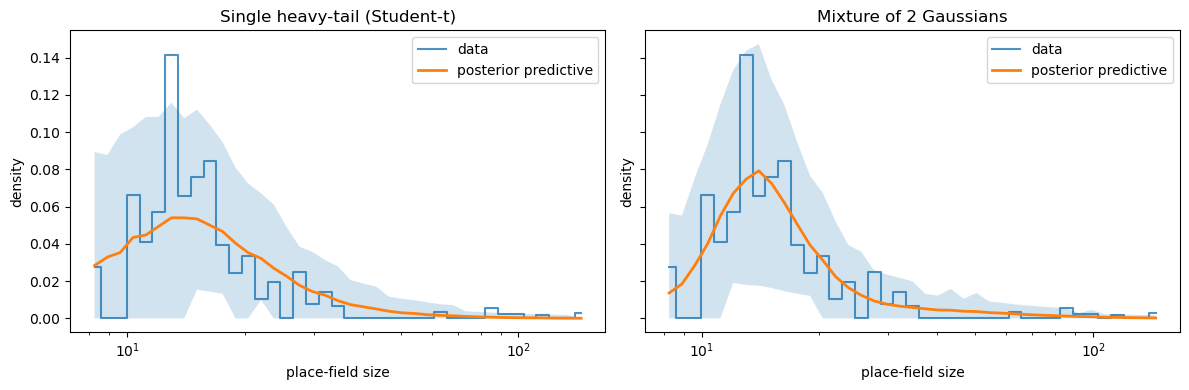

In [12]:
# y: >0 sizes in original units; rec_idx: 0..R-1
y_pos = np.clip(y, 1e-6, None)
y_log = np.log(y_pos)
ybar, ysd = float(y_log.mean()), float(y_log.std(ddof=0))
y_std = (y_log - ybar) / ysd
N = y_std.size

# ---------------------------------------
# Model S: single heavy-tail (Student-t)
# ---------------------------------------
with pm.Model() as model_single_t:
    # non-centered hierarchical location on standardized log-scale
    mu0_std   = pm.Normal("mu0_std", 0.0, 1.5)
    tau_std   = pm.HalfNormal("tau_std", 0.5)         # between-recording SD (std units)
    sigma_std = pm.HalfNormal("sigma_std", 0.5)       # within SD (std units)
    z_r = pm.Normal("z_r", 0.0, 1.0, shape=R)
    mu_r_std = pm.Deterministic("mu_r_std", mu0_std + tau_std * z_r[rec_idx])

    # heavy tail via Student-t (nu > 2 → finite variance)
    nu = pm.Exponential("nu_minus2", 1/15) + 2
    y_std_obs = pm.StudentT("y_std_obs", nu=nu, mu=mu_r_std, sigma=sigma_std, observed=y_std)

    # back-transform (log-scale params for interpretability)
    mu0   = pm.Deterministic("mu0",   mu0_std * ysd + ybar)
    tau   = pm.Deterministic("tau",   tau_std * ysd)
    sigma = pm.Deterministic("sigma", sigma_std * ysd)

    idata_single = pm.sample(draws=3000, tune=3000, chains=4, random_seed=41,
                             init="jitter+adapt_diag", target_accept=0.99,
                             idata_kwargs={"log_likelihood": True})
    ppc_single   = pm.sample_posterior_predictive(idata_single)
    loo_single   = az.loo(idata_single, var_name="y_std_obs", pointwise=True)

print(az.summary(idata_single, var_names=["mu0","tau","sigma","nu_minus2"]))

# ---------------------------------------------------------
# Model M: 2-Gaussian mixture (ordered means, shared shift)
# ---------------------------------------------------------
with pm.Model() as model_mix2:
    # ordered global means on standardized log-scale (identifiable)
    mu_center_std = pm.Normal("mu_center_std", 0.0, 1.5)
    delta_std     = pm.HalfNormal("delta_std", 0.7)
    mu1_std = pm.Deterministic("mu1_std", mu_center_std - 0.5 * delta_std)
    mu2_std = pm.Deterministic("mu2_std", mu_center_std + 0.5 * delta_std)

    # one recording random intercept shared by both components
    tau_std = pm.HalfNormal("tau_std", 0.5)
    z_r = pm.Normal("z_r", 0.0, 1.0, shape=R)
    a_r = tau_std * z_r[rec_idx]

    mu1_r_std = pm.Deterministic("mu1_r_std", mu1_std + a_r)
    mu2_r_std = pm.Deterministic("mu2_r_std", mu2_std + a_r)

    # component scales
    sigma1_std = pm.HalfNormal("sigma1_std", 0.5)
    sigma2_std = pm.HalfNormal("sigma2_std", 0.5)

    # global mixture weight (no covariates here)
    w2 = pm.Beta("w2", 1, 1)  # Prob(component 2). Weight vector is [1-w2, w2]
    w = pt.stack([1 - w2, w2])

    comp1 = pm.Normal.dist(mu=mu1_r_std, sigma=sigma1_std)
    comp2 = pm.Normal.dist(mu=mu2_r_std, sigma=sigma2_std)
    y_std_mix = pm.Mixture("y_std_mix", w=w, comp_dists=[comp1, comp2], observed=y_std)

    # back-transform to log-scale (medians on original scale = exp(mu*))
    mu1   = pm.Deterministic("mu1",   mu1_std * ysd + ybar)
    mu2   = pm.Deterministic("mu2",   mu2_std * ysd + ybar)
    tau   = pm.Deterministic("tau",   tau_std * ysd)
    sigma1 = pm.Deterministic("sigma1", sigma1_std * ysd)
    sigma2 = pm.Deterministic("sigma2", sigma2_std * ysd)

    idata_mix = pm.sample(draws=4000, tune=4000, chains=4, random_seed=43,
                          init="jitter+adapt_diag", target_accept=0.99,
                          nuts_kwargs=dict(max_treedepth=15),
                          idata_kwargs={"log_likelihood": True})
    ppc_mix   = pm.sample_posterior_predictive(idata_mix)
    loo_mix   = az.loo(idata_mix, var_name="y_std_mix", pointwise=True)

print(az.summary(idata_mix, var_names=["mu1","mu2","sigma1","sigma2","w2"]))

# ---------------------
# Compare & visualize
# ---------------------
cmp = az.compare({"single_t": idata_single, "mix2": idata_mix}, ic="loo", method="BB-pseudo-BMA")
print("\n=== LOO comparison (higher elpd_loo is better) ===")
print(cmp)

# Posterior predictive overlay (overall), back to original units
import matplotlib.pyplot as plt

def back_ppc(ppc, var, ybar, ysd, max_draws=1000):
    arr = ppc.posterior_predictive[var].values  # (chain, draw, N)
    S = arr.shape[0] * arr.shape[1]
    if S > max_draws:
        rng = np.random.default_rng(0)
        # reshape then subsample draws
        arr = arr.reshape(S, arr.shape[-1])[rng.choice(S, max_draws, replace=False)]
    else:
        arr = arr.reshape(S, arr.shape[-1])
    return np.exp(ybar + ysd * arr)

bins = np.logspace(np.log10(y_pos.min()), np.log10(y_pos.max()), 40)

def plot_data_vs_ppc(ax, y_obs, y_ppc, bins, title):
    h, _ = np.histogram(y_obs, bins=bins, density=True)
    centers = 0.5*(bins[:-1] + bins[1:])
    ax.step(centers, h, where="mid", label="data", alpha=0.8)
    # compute PPC band
    H = np.array([np.histogram(s, bins=bins, density=True)[0] for s in y_ppc])
    ax.plot(centers, H.mean(0), lw=2, label="posterior predictive")
    ax.fill_between(centers, np.quantile(H, 0.05, 0), np.quantile(H, 0.95, 0), alpha=0.2)
    ax.set_xscale("log"); ax.set_xlabel("place-field size"); ax.set_ylabel("density"); ax.set_title(title); ax.legend()

yppc_single = back_ppc(ppc_single, "y_std_obs", ybar, ysd)
yppc_mix    = back_ppc(ppc_mix,    "y_std_mix", ybar, ysd)

fig, axes = plt.subplots(1, 2, figsize=(12,4), sharey=True)
plot_data_vs_ppc(axes[0], y_pos, yppc_single, bins, "Single heavy-tail (Student-t)")
plot_data_vs_ppc(axes[1], y_pos, yppc_mix,    bins, "Mixture of 2 Gaussians")
plt.tight_layout(); plt.show()

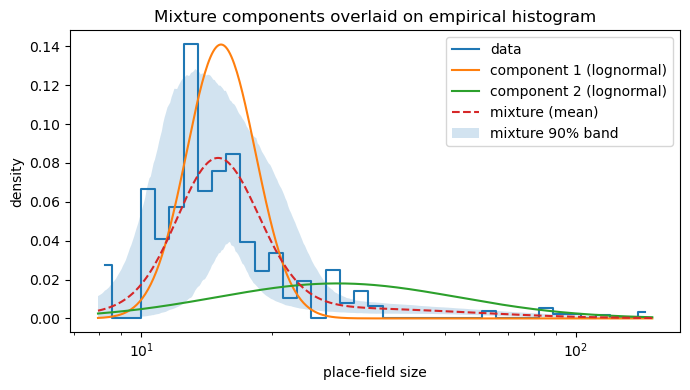

In [21]:
post = idata_mix.posterior

# Posterior draws of log-scale (original units) params and global weight
mu1_draw = post["mu1"].values.reshape(-1)      # log-median of comp1
mu2_draw = post["mu2"].values.reshape(-1)      # log-median of comp2
s1_draw  = post["sigma1"].values.reshape(-1)   # log-scale SD comp1
s2_draw  = post["sigma2"].values.reshape(-1)   # log-scale SD comp2
w2_draw  = post["w2"].values.reshape(-1)       # P(component 2)

# Grid on original scale (positive, right-skewed → log-spaced)
x = np.logspace(np.log10(y.min()), np.log10(y.max()), 400)

def lognorm_pdf(x, mu, sigma):
    return (1.0/(x * sigma * np.sqrt(2*np.pi))) * np.exp(-0.5*((np.log(x) - mu)/sigma)**2)

# "Representative" component curves via posterior medians
mu1_m, mu2_m = np.median(mu1_draw), np.median(mu2_draw)
s1_m, s2_m   = np.median(s1_draw),  np.median(s2_draw)
w2_m         = np.median(w2_draw)

f1_m = lognorm_pdf(x, mu1_m, s1_m)
f2_m = lognorm_pdf(x, mu2_m, s2_m)
mix_m = (1 - w2_m)*f1_m + w2_m*f2_m

# Credible band for the mixture density
rng = np.random.default_rng(0)
idx = rng.choice(len(mu1_draw), size=min(1000, len(mu1_draw)), replace=False)
F = []
for i in idx:
    f1 = lognorm_pdf(x, mu1_draw[i], s1_draw[i])
    f2 = lognorm_pdf(x, mu2_draw[i], s2_draw[i])
    F.append((1 - w2_draw[i]) * f1 + w2_draw[i] * f2)
F = np.asarray(F)
mix_lo, mix_hi = np.quantile(F, [0.05, 0.95], axis=0)
mix_mean = F.mean(axis=0)

# Empirical histogram (density) on the same x-grid
bins = np.logspace(np.log10(y.min()), np.log10(y.max()), 40)
h, _ = np.histogram(y, bins=bins, density=True)
centers = 0.5*(bins[:-1] + bins[1:])

# ----- Plot -----
fig, ax = plt.subplots(figsize=(7,4))
ax.set_xscale("log")
ax.step(centers, h, where="mid", label="data")
ax.plot(x, f1_m, label="component 1 (lognormal)")
ax.plot(x, f2_m, label="component 2 (lognormal)")
ax.plot(x, mix_mean, linestyle="--", label="mixture (mean)")
ax.fill_between(x, mix_lo, mix_hi, alpha=0.2, label="mixture 90% band")
ax.set_xlabel("place-field size")
ax.set_ylabel("density")
ax.set_title("Mixture components overlaid on empirical histogram")
ax.legend()
plt.tight_layout()
plt.show()

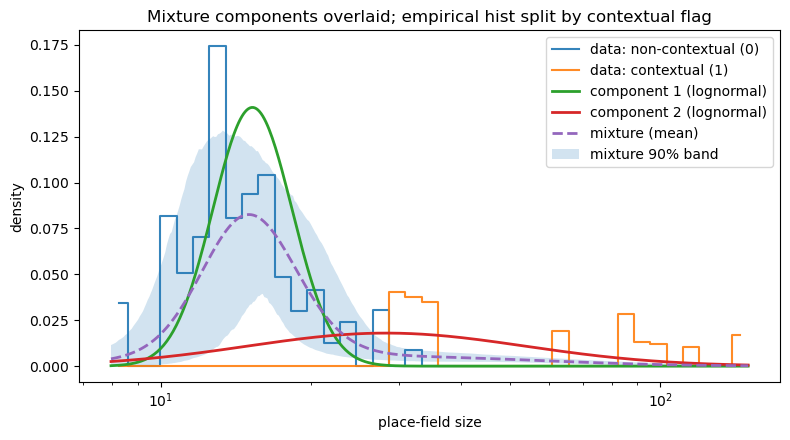

In [23]:
# --- grab posterior draws from the fitted 2-component mixture ---
post = idata_mix.posterior
mu1_draw = post["mu1"].values.reshape(-1)      # log-median comp1
mu2_draw = post["mu2"].values.reshape(-1)      # log-median comp2
s1_draw  = post["sigma1"].values.reshape(-1)   # log-scale SD comp1
s2_draw  = post["sigma2"].values.reshape(-1)   # log-scale SD comp2
w2_draw  = post["w2"].values.reshape(-1)       # global mixture weight (comp2)

# representative component curves via posterior medians
mu1_m, mu2_m = np.median(mu1_draw), np.median(mu2_draw)
s1_m,  s2_m  = np.median(s1_draw),  np.median(s2_draw)
w2_m         = np.median(w2_draw)

def lognorm_pdf(x, mu, sigma):
    return (1.0/(x * sigma * np.sqrt(2*np.pi))) * np.exp(-0.5*((np.log(x) - mu)/sigma)**2)

# x-grid on original scale
x = np.logspace(np.log10(y.min()), np.log10(y.max()), 400)

# component and mixture curves
f1_m  = lognorm_pdf(x, mu1_m, s1_m)
f2_m  = lognorm_pdf(x, mu2_m, s2_m)
mix_m = (1 - w2_m)*f1_m + w2_m*f2_m

# mixture credible band
rng = np.random.default_rng(0)
idx = rng.choice(len(mu1_draw), size=min(1000, len(mu1_draw)), replace=False)
F = []
for i in idx:
    f1 = lognorm_pdf(x, mu1_draw[i], s1_draw[i])
    f2 = lognorm_pdf(x, mu2_draw[i], s2_draw[i])
    F.append((1 - w2_draw[i]) * f1 + w2_draw[i] * f2)
F = np.asarray(F)
mix_lo, mix_hi = np.quantile(F, [0.05, 0.95], axis=0)
mix_mean = F.mean(axis=0)

# --- empirical histograms split by contextual flag ---
mask0 = (contextual == 0)
mask1 = (contextual == 1)

# shared log-spaced bins so the two histograms are comparable
bins = np.logspace(np.log10(y.min()), np.log10(y.max()), 40)

h0, _ = np.histogram(y[mask0], bins=bins, density=True)
h1, _ = np.histogram(y[mask1], bins=bins, density=True)
centers = 0.5*(bins[:-1] + bins[1:])

# --- plot ---
fig, ax = plt.subplots(figsize=(8,4.5))
ax.set_xscale("log")

# empirical data (two colors)
ax.step(centers, h0, where="mid", label="data: non-contextual (0)", alpha=0.9)
ax.step(centers, h1, where="mid", label="data: contextual (1)", alpha=0.9)

# components and mixture
ax.plot(x, f1_m, label="component 1 (lognormal)", linewidth=2)
ax.plot(x, f2_m, label="component 2 (lognormal)", linewidth=2)
ax.plot(x, mix_mean, linestyle="--", label="mixture (mean)", linewidth=2)
ax.fill_between(x, mix_lo, mix_hi, alpha=0.2, label="mixture 90% band")

ax.set_xlabel("place-field size")
ax.set_ylabel("density")
ax.set_title("Mixture components overlaid; empirical hist split by contextual flag")
ax.legend()
plt.tight_layout()
plt.show()

In [27]:
df_main = pl.read_csv(PATH, separator=SEPARATOR)

# sanity: make sure expected columns exist (rename here if yours differ)
needed = {"recording_id", "neuron_id", SIZE_COL, "putative_contextual"}
missing = needed - set(df_main.columns)
if missing:
    raise ValueError(f"Missing columns: {missing}. Have: {df_main.columns}")

# map recording_id -> 0..R-1 (stable)
rec_map = (
    df_main.select("recording_id")
           .unique()
           .sort("recording_id")
           .with_row_index(name="rec_idx")
)

# keep length in your Polars frame
df = (
    df_main.join(rec_map, on="recording_id")
           .with_columns(
               pl.col("putative_contextual").cast(pl.Int8).alias("contextual"),
               pl.col(SIZE_COL).cast(pl.Float64).alias("size"),
           )
           .select("rec_idx","recording_id","neuron_id","size","contextual","length_of_VR")
)

# numpy arrays
y          = df["size"].to_numpy()
rec_idx    = df["rec_idx"].to_numpy().astype(np.int64)
contextual = df["contextual"].to_numpy().astype(np.int8)
length     = df["length_of_VR"].to_numpy().astype(np.int64)   # values in {150, 200}
L200       = (length == 200).astype(np.int8)                   # 0/1 indicator

# standardize the outcome (log-size), as before
import numpy as np
y_pos = np.clip(y, 1e-6, None)
y_log = np.log(y_pos)
ybar, ysd = float(y_log.mean()), float(y_log.std(ddof=0))
y_std = (y_log - ybar)/ysd
R = int(df["rec_idx"].max()) + 1

In [28]:
with pm.Model() as model_mix_len:
    # ordered global means (identifiability) on the standardized log-scale
    mu_center_std = pm.Normal("mu_center_std", 0.0, 1.5)
    delta_std     = pm.HalfNormal("delta_std", 0.7)
    mu1_std = pm.Deterministic("mu1_std", mu_center_std - 0.5*delta_std)
    mu2_std = pm.Deterministic("mu2_std", mu_center_std + 0.5*delta_std)

    # recording random intercept shared by both components
    tau_std = pm.HalfNormal("tau_std", 0.5)
    z_r = pm.Normal("z_r", 0.0, 1.0, shape=R)
    a_r = tau_std * z_r[rec_idx]

    # length effect on *small* component mean (standardized log-scale)
    gamma1 = pm.Normal("gamma1", 0.0, 0.7)   # effect of L200 on comp-1 mean
    mu1_r_std = pm.Deterministic("mu1_r_std", mu1_std + a_r + gamma1 * L200)
    mu2_r_std = pm.Deterministic("mu2_r_std", mu2_std + a_r)

    # component scales
    sigma1_std = pm.HalfNormal("sigma1_std", 0.5)
    sigma2_std = pm.HalfNormal("sigma2_std", 0.5)

    # global mixture weight
    w2 = pm.Beta("w2", 1, 1)
    w = pt.stack([1 - w2, w2])

    comp1 = pm.Normal.dist(mu=mu1_r_std, sigma=sigma1_std)
    comp2 = pm.Normal.dist(mu=mu2_r_std, sigma=sigma2_std)
    y_std_mix = pm.Mixture("y_std_mix", w=w, comp_dists=[comp1, comp2], observed=y_std)

    # back-transform (log units) for interpretability
    mu1   = pm.Deterministic("mu1",   mu1_std * ysd + ybar)          # baseline small-comp median (log)
    mu2   = pm.Deterministic("mu2",   mu2_std * ysd + ybar)
    sigma1 = pm.Deterministic("sigma1", sigma1_std * ysd)
    sigma2 = pm.Deterministic("sigma2", sigma2_std * ysd)
    # EFFECT of 200 vs 150 on the small component's median:
    # ratio (200 vs 150) on original scale = exp(gamma1 * ysd)
    ratio_200vs150 = pm.Deterministic("ratio_200vs150", pm.math.exp(gamma1 * ysd))

    idata_mix_len = pm.sample(
        draws=4000, tune=4000, chains=4, random_seed=44,
        init="jitter+adapt_diag", target_accept=0.99,
        nuts_kwargs=dict(max_treedepth=15),
        idata_kwargs={"log_likelihood": True}
    )
    ppc_mix_len = pm.sample_posterior_predictive(idata_mix_len)

loo_mix_len = az.loo(idata_mix_len, var_name="y_std_mix", pointwise=True)
print(az.summary(idata_mix_len, var_names=["gamma1","ratio_200vs150","mu1","mu2","sigma1","sigma2","w2"]))

c:\Users\anneluka\.conda\envs\bayes-pymc\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_center_std, delta_std, tau_std, z_r, gamma1, sigma1_std, sigma2_std, w2]


Output()

Sampling 4 chains for 4_000 tune and 4_000 draw iterations (16_000 + 16_000 draws total) took 188 seconds.
Sampling: [y_std_mix]


Output()

                 mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
gamma1         -0.057  0.281  -0.587    0.465      0.004    0.003    5567.0   
ratio_200vs150  0.979  0.198   0.624    1.338      0.003    0.002    5567.0   
mu1             2.778  0.149   2.493    3.059      0.002    0.001    4532.0   
mu2             3.735  0.268   3.222    4.221      0.004    0.002    4749.0   
sigma1          0.186  0.036   0.126    0.256      0.000    0.000    8665.0   
sigma2          0.652  0.135   0.402    0.906      0.002    0.001    7079.0   
w2              0.329  0.091   0.161    0.499      0.001    0.001    7512.0   

                ess_tail  r_hat  
gamma1            7825.0    1.0  
ratio_200vs150    7825.0    1.0  
mu1               6872.0    1.0  
mu2               6227.0    1.0  
sigma1            7396.0    1.0  
sigma2            8802.0    1.0  
w2                8539.0    1.0  


In [30]:
r = idata_mix_len.posterior["ratio_200vs150"].values.reshape(-1)
print("ratio_200vs150 mean/median:", r.mean(), np.median(r))
# print("95% HDI:", az.hdi(r, hdi_prob=0.95).values)
print("P(ratio>1):", (r>1.0).mean())
print("P(ratio>1.2):", (r>1.2).mean())
print("P(ratio>1.33):", (r>1.33).mean())

ratio_200vs150 mean/median: 0.9794185420186554 0.9608840065054345
P(ratio>1): 0.418
P(ratio>1.2): 0.1249375
P(ratio>1.33): 0.0474375


In [31]:
cmp = az.compare(
    {"mix2_base": idata_mix, "mix2_len": idata_mix_len, "single_t": idata_single},
    ic="loo", method="BB-pseudo-BMA"
)
print(cmp)

           rank   elpd_loo      p_loo  elpd_diff    weight        se  \
mix2_base     0 -60.575445  12.162454   0.000000  0.647265  7.560474   
mix2_len      1 -61.193022  12.855442   0.617577  0.352728  7.553505   
single_t      2 -79.714331  16.995558  19.138886  0.000007  8.299679   

                dse  warning scale  
mix2_base  0.000000    False   log  
mix2_len   0.246690    False   log  
single_t   4.709186    False   log  


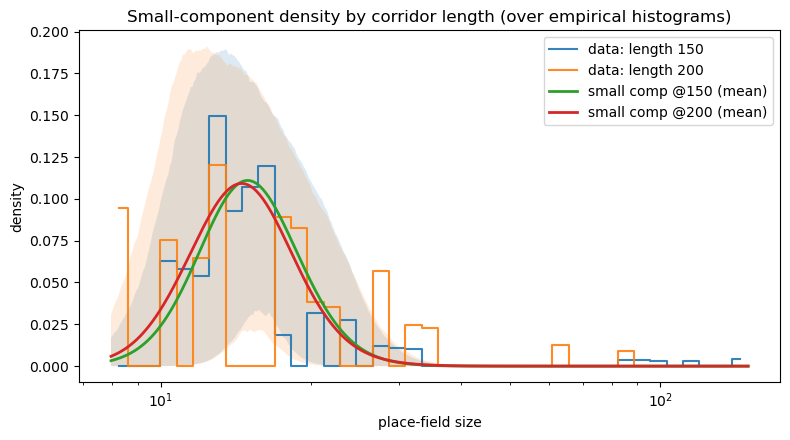

In [32]:
post = idata_mix_len.posterior
mu1_std_draw  = post["mu1_std"].values.reshape(-1)
sigma1_std_draw = post["sigma1_std"].values.reshape(-1)
gamma1_draw   = post["gamma1"].values.reshape(-1)

# transform to original log units for each condition
mu1_150 = ybar + ysd * (mu1_std_draw + 0*gamma1_draw)
mu1_200 = ybar + ysd * (mu1_std_draw + 1*gamma1_draw)
s1      = ysd * sigma1_std_draw

def lognorm_pdf(x, mu, sigma):
    return (1.0/(x*sigma*np.sqrt(2*np.pi)))*np.exp(-0.5*((np.log(x)-mu)/sigma)**2)

# grid and credible bands
x = np.logspace(np.log10(y_pos.min()), np.log10(y_pos.max()), 400)
rng = np.random.default_rng(0)
idx = rng.choice(len(mu1_150), size=min(1000, len(mu1_150)), replace=False)

F150 = np.vstack([lognorm_pdf(x, mu1_150[i], s1[i]) for i in idx])
F200 = np.vstack([lognorm_pdf(x, mu1_200[i], s1[i]) for i in idx])

f150_mean, f150_lo, f150_hi = F150.mean(0), np.quantile(F150, 0.05, 0), np.quantile(F150, 0.95, 0)
f200_mean, f200_lo, f200_hi = F200.mean(0), np.quantile(F200, 0.05, 0), np.quantile(F200, 0.95, 0)

# empirical histograms split by length
bins = np.logspace(np.log10(y_pos.min()), np.log10(y_pos.max()), 40)
h150, _ = np.histogram(y_pos[length==150], bins=bins, density=True)
h200, _ = np.histogram(y_pos[length==200], bins=bins, density=True)
centers = 0.5*(bins[:-1] + bins[1:])

fig, ax = plt.subplots(figsize=(8,4.5))
ax.set_xscale("log")

# data histograms
ax.step(centers, h150, where="mid", label="data: length 150", alpha=0.9)
ax.step(centers, h200, where="mid", label="data: length 200", alpha=0.9)

# small-component densities (posterior means + 90% bands)
ax.plot(x, f150_mean, label="small comp @150 (mean)", linewidth=2)
ax.fill_between(x, f150_lo, f150_hi, alpha=0.15)

ax.plot(x, f200_mean, label="small comp @200 (mean)", linewidth=2)
ax.fill_between(x, f200_lo, f200_hi, alpha=0.15)

ax.set_xlabel("place-field size")
ax.set_ylabel("density")
ax.set_title("Small-component density by corridor length (over empirical histograms)")
ax.legend()
plt.tight_layout(); plt.show()